# Time Series Forecasting with Switch Transformer

This script demonstrates the implementation of a Switch Transformer for electricity load forecasting. 

The Switch Transformer replaces the feedforward network (FFN) layer in the standard Transformer with a Mixture of Expert (MoE) routing layer, where each expert operates independently on the tokens in the sequence. This allows increasing the model size without increasing the computation needed to process each example.

Note that, for training the Switch Transformer efficiently, data and model parallelism need to be applied, so that expert modules can run simultaneously, each on its own accelerator. While the implementation described in the paper uses the TensorFlow Mesh framework for distributed training, this example presents a simple, non-distributed implementation of the Switch Transformer model for demonstration purposes.

### Setup

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import os
from windowgenerator import *

### Download and prepare dataset

In [29]:
train_df_F5['User1']

0       0.068
1       0.786
2       0.544
3       0.612
4       0.665
        ...  
6127    0.139
6128    0.213
6129    0.030
6130    0.138
6131    0.227
Name: User1, Length: 6132, dtype: float64

In [66]:
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/final_data/final_dataset.csv', encoding= 'unicode_escape', index_col='Date')
df.index = pd.to_datetime(df.index)
df.drop(columns=['wdir','pres', 'dwpt', 'wspd'], axis=1, inplace=True)

In [67]:
#Convert Time String to seconds
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

#Sine cosine Scaling
hour = 60*60
df['hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))

daysinweek = 7*24*60*60
df['dayofweek sin'] = np.sin(timestamp_s * (2 * np.pi / daysinweek))
df['dayofweek cos'] = np.cos(timestamp_s * (2 * np.pi / daysinweek))

#Min Max Sclaing
col_names = df.columns
features = df[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
df = pd.DataFrame(features, columns = col_names, index=df.index)

In [69]:
df

,Date,User1,User10,User11,User12,User13,User14,User15,User16,User17,...,User6,User7,User8,User9,temp,dwpt,rhum,wdir,wspd,pres
0,2012-07-01 00:00:00,0.068,0.703,0.353,0.210,0.138,0.208,0.065,0.340,0.129,...,0.636,0.106,0.156,0.012,5.1,4.5,96.0,NaN,0.0,1015.2
1,2012-07-01 01:00:00,0.786,0.036,0.547,0.197,0.343,0.176,0.067,0.508,0.121,...,0.253,0.098,0.151,0.022,5.1,4.5,96.0,NaN,0.0,1015.2
2,2012-07-01 02:00:00,0.544,0.045,0.519,0.163,0.339,0.164,0.057,0.542,0.141,...,0.220,0.089,0.152,0.023,5.1,4.5,96.0,NaN,0.0,1015.2
3,2012-07-01 03:00:00,0.612,0.031,0.324,0.173,0.337,0.178,0.063,0.590,0.165,...,0.241,0.103,0.148,0.012,2.7,2.3,97.0,200.0,7.6,1014.8
4,2012-07-01 04:00:00,0.665,0.018,0.343,0.156,0.363,0.193,0.065,0.551,0.122,...,0.199,0.090,0.146,0.038,2.7,2.3,97.0,200.0,7.6,1014.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-06-30 19:00:00,0.335,0.198,1.362,1.385,0.237,0.331,0.082,0.671,0.418,...,1.018,0.066,0.563,0.089,11.8,9.9,88.0,250.0,3.6,1025.0
8756,2013-06-30 20:00:00,0.213,0.873,0.687,1.347,0.282,0.940,0.095,0.507,0.510,...,0.910,0.103,0.104,0.053,11.8,9.9,88.0,250.0,3.6,1025.0
8757,2013-06-30 21:00:00,0.190,0.113,0.675,1.615,1.193,0.290,0.115,0.219,0.487,...,1.011,0.076,0.086,0.048,8.8,8.7,99.0,30.0,1.8,1025.4
8758,2013-06-30 22:00:00,0.274,0.092,0.747,1.636,0.132,0.265,0.080,0.105,0.197,...,1.063,0.084,0.203,0.072,8.8,8.7,99.0,30.0,1.8,1025.4


In [68]:
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/final_data/final_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])


n = len(df)
train_df_F5 = df[0:int(n*0.7)][['User1', 'temp', 'rhum', 'Date', 'dwpt']]
val_df_F5 = df[int(n*0.7):int(n*0.9)][['User1','temp', 'rhum', 'Date', 'dwpt']]
test_df_F5 = df[int(n*0.9):][['User1', 'temp', 'rhum', 'Date', 'dwpt']]

window = WindowGenerator(
    input_width=24, label_width=1, shift=1, 
    train_df = train_df_F5, val_df = val_df_F5, test_df = test_df_F5, label_columns=['User1']
)
train_df_F5
example_window = tf.stack([np.array(train_df_F5[:window.total_window_size]),
                           np.array(train_df_F5[100:100+window.total_window_size]),
                           np.array(train_df_F5[200:200+window.total_window_size])])


example_inputs, example_labels = window.split_window(example_window)
window.example = example_inputs, example_labels

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [16]:
"""
vocab_size = 20000  # Only consider the 20k most frequent words
num_tokens_per_example = 200  # Only consider the first 200 words of each movie review

# This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). 
# Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). 
# For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. 
# This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

# x_train, x_test: lists of sequences, which are lists of indexes (integers). 
# If the num_words argument was specific, the maximum possible index value is num_words - 1. 
# If the maxlen argument was specified, the largest possible sequence length is maxlen.

# y_train, y_test: lists of integer labels (1 or 0).
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences - Shape ", x_train.shape)
# This function transforms a list of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). 
# num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.
# Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.
x_train = keras.utils.pad_sequences(
    x_train, maxlen=num_tokens_per_example
)
x_val = keras.utils.pad_sequences(x_val, maxlen=num_tokens_per_example)

print(len(x_train), "Training sequences - Shape ", x_train.shape)
print(len(x_val), "Validation sequences - Shape ", x_val.shape)
"""

# ------------------------------------- Load dataset ------------------------------------
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/final_data/final_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
TIME_STEPS = 24
vocab_size = 24 
num_tokens_per_example = 24  # Only consider the first 200 words of each movie review

# Split into input (X) and output (y) variables
X = df['User1'] #df[['temp', 'hour', 'User5']]
y = df['User1']

# Train test split
train_size = int(len(X) * 0.8)
x_train, x_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Function to create sequences or window generator
def create_sequences(X, y, time_steps):
  Xs, ys = [] , []
  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:i+time_steps].values)
    ys.append(y.iloc[i+time_steps])

  return np.array(Xs), np.array(ys)

# Create sequences with a time window of 24
x_train, y_train = create_sequences(x_train, y_train, TIME_STEPS)
x_val, y_val = create_sequences(x_val, y_val, TIME_STEPS)

print(len(x_train), "Training sequences - Shape ", x_train.shape)
print(len(x_val), "Validation sequences - Shape ", x_val.shape)

6984 Training sequences - Shape  (6984, 24)
1728 Validation sequences - Shape  (1728, 24)


<Axes: >

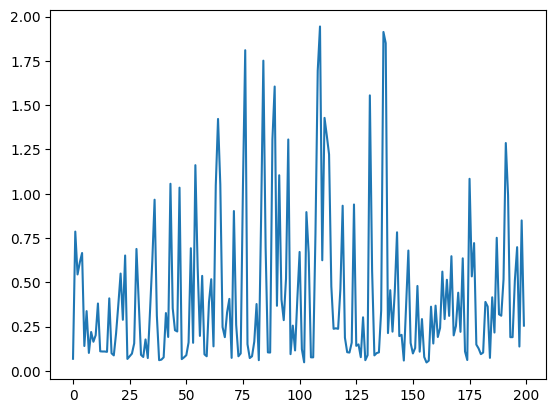

In [19]:
df['User1'][0:200].plot()

In [21]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=20)
])

MAX_EPOCHS = 20

def compile_and_fit(model, x_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(x=x_train, y=y_train, epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, x_train, y_train)

linear.evaluate(x=x_val, y=y_val)

Epoch 1/20
219/219 [==============================] - 0s 610us/step - loss: 0.1863 - mean_absolute_error: 0.3171
Epoch 2/20
219/219 [==============================] - 0s 557us/step - loss: 0.1115 - mean_absolute_error: 0.2433
Epoch 3/20
219/219 [==============================] - 0s 569us/step - loss: 0.0889 - mean_absolute_error: 0.2143
Epoch 4/20
219/219 [==============================] - 0s 574us/step - loss: 0.0777 - mean_absolute_error: 0.1983
Epoch 5/20
219/219 [==============================] - 0s 564us/step - loss: 0.0721 - mean_absolute_error: 0.1895
Epoch 6/20
219/219 [==============================] - 0s 555us/step - loss: 0.0693 - mean_absolute_error: 0.1858
Epoch 7/20
219/219 [==============================] - 0s 550us/step - loss: 0.0678 - mean_absolute_error: 0.1826
Epoch 8/20
219/219 [==============================] - 0s 546us/step - loss: 0.0671 - mean_absolute_error: 0.1814
Epoch 9/20
219/219 [==============================] - 0s 546us/step - loss: 0.0668 - mean_absolu

[0.0833497941493988, 0.2014768421649933]

### Define Hyperparameters

In [3]:


#embed_dim = 1  # Embedding size for each token.
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.

num_experts = 10  # Number of experts used in the Switch Transformer.

batch_size = 8  # Batch size.

learning_rate = 0.001  # Learning rate.
dropout_rate = 0.25  # Dropout rate.

num_epochs = 3  # Number of epochs.

num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.

print(f"Number of tokens per batch: {num_tokens_per_batch}")

Number of tokens per batch: 192


## Implement token & position embedding layer

It consists of two seperate embedding layers, one for tokens, one for token index (positions).

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Implement the feedforward network

This is used as the Mixture of Experts in the Switch Transformer.

In [5]:
def create_feedforward_network(ff_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(ff_dim)], name=name
    )


## Implement the load-balanced loss

This is an auxiliary loss to encourage a balanced load across experts.

In [6]:
def load_balanced_loss(router_probs, expert_mask):
    # router_probs [tokens_per_batch, num_experts] is the probability assigned for
    # each expert per token. expert_mask [tokens_per_batch, num_experts] contains
    # the expert with the highest router probability in one−hot format.

    num_experts = tf.shape(expert_mask)[-1]
    # Get the fraction of tokens routed to each expert.
    # density is a vector of length num experts that sums to 1.
    density = tf.reduce_mean(expert_mask, axis=0)
    # Get fraction of probability mass assigned to each expert from the router
    # across all tokens. density_proxy is a vector of length num experts that sums to 1.
    density_proxy = tf.reduce_mean(router_probs, axis=0)
    # Want both vectors to have uniform allocation (1/num experts) across all
    # num_expert elements. The two vectors will be pushed towards uniform allocation
    # when the dot product is minimized.
    loss = tf.reduce_mean(density_proxy * density) * tf.cast(
        (num_experts ** 2), tf.dtypes.float32
    )
    return loss

### Implement the router as a layer

In [7]:
class Router(layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        self.num_experts = num_experts
        self.route = layers.Dense(units=num_experts)
        self.expert_capacity = expert_capacity
        super().__init__()

    def call(self, inputs, training=False):
        # inputs shape: [tokens_per_batch, embed_dim]
        # router_logits shape: [tokens_per_batch, num_experts]
        router_logits = self.route(inputs)

        if training:
            # Add noise for exploration across experts.
            router_logits += tf.random.uniform(
                shape=router_logits.shape, minval=0.9, maxval=1.1
            )
        # Probabilities for each token of what expert it should be sent to.
        router_probs = keras.activations.softmax(router_logits, axis=-1)
        # Get the top−1 expert for each token. expert_gate is the top−1 probability
        # from the router for each token. expert_index is what expert each token
        # is going to be routed to.
        expert_gate, expert_index = tf.math.top_k(router_probs, k=1)
        # expert_mask shape: [tokens_per_batch, num_experts]
        expert_mask = tf.one_hot(expert_index, depth=self.num_experts)
        # Compute load balancing loss.
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        self.add_loss(aux_loss)
        # Experts have a fixed capacity, ensure we do not exceed it. Construct
        # the batch indices, to each expert, with position in expert make sure that
        # not more that expert capacity examples can be routed to each expert.
        position_in_expert = tf.cast(
            tf.math.cumsum(expert_mask, axis=0) * expert_mask, tf.dtypes.int32
        )
        # Keep only tokens that fit within expert capacity.
        expert_mask *= tf.cast(
            tf.math.less(
                tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity
            ),
            tf.dtypes.float32,
        )
        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        # Mask out the experts that have overflowed the expert capacity.
        expert_gate *= expert_mask_flat
        # Combine expert outputs and scaling with router probability.
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        combined_tensor = tf.expand_dims(
            expert_gate
            * expert_mask_flat
            * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts), 1),
            -1,
        ) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)
        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor

### Implement a Switch layer

In [8]:
class Switch(layers.Layer):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, capacity_factor=1):
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(embed_dim) for _ in range(num_experts)
        ]

        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)
        super().__init__()

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]

        # inputs shape: [num_tokens_per_batch, embed_dim]
        inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])
        # dispatch_tensor shape: [expert_capacity, num_experts, tokens_per_batch]
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        dispatch_tensor, combine_tensor = self.router(inputs)
        # expert_inputs shape: [num_experts, expert_capacity, embed_dim]
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        # Dispatch to experts
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        # expert_outputs shape: [expert_capacity, num_experts, embed_dim]
        expert_outputs = tf.stack(expert_output_list, axis=1)
        # expert_outputs_combined shape: [tokens_per_batch, embed_dim]
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        # output shape: [batch_size, num_tokens_per_example, embed_dim]
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )
        return outputs

## Implement a Transformer block layer

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn, dropout_rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # The ffn can be either a standard feedforward network or a switch
        # layer with a Mixture of Experts.
        self.ffn = ffn
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement the classifier

The `TransformerBlock` layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and use a feedforward network on top
of it to classify text.

In [10]:
def create_model():
    switch = Switch(num_experts, embed_dim, num_tokens_per_batch)
    transformer_block = TransformerBlock(ff_dim, num_heads, switch)
    #INPUTS = (num_tokens_per_example,None,)
    inputs = layers.Input(shape=(num_tokens_per_example,))
    
    embedding_layer = TokenAndPositionEmbedding(
        num_tokens_per_example, vocab_size, embed_dim
    )
    x = embedding_layer(inputs)
   
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Train and evaluate the model

In [11]:
def run_experiment(regressor):
    regressor.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    history = regressor.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
    )
    return history


regressor = create_model()
run_experiment(regressor)

ValueError: Exception encountered when calling layer "transformer_block" (type TransformerBlock).

in user code:

    File "C:\Users\rs1044\AppData\Local\Temp\ipykernel_22008\1570579536.py", line 17, in call  *
        ffn_output = self.ffn(out1)
    File "c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\rs1044\AppData\Local\Temp\__autograph_generated_file68szwklt.py", line 12, in tf__call
        inputs = ag__.converted_call(ag__.ld(tf).reshape, (ag__.ld(inputs), [ag__.ld(num_tokens_per_batch), ag__.ld(self).embed_dim]), None, fscope)

    ValueError: Exception encountered when calling layer 'switch' (type Switch).
    
    in user code:
    
        File "C:\Users\rs1044\AppData\Local\Temp\ipykernel_22008\1948486710.py", line 18, in call  *
            inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])
    
        ValueError: Dimension size must be evenly divisible by 216 but is 576 for '{{node transformer_block/switch/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](transformer_block/layer_normalization/batchnorm/add_1, transformer_block/switch/Reshape/shape)' with input shapes: [?,24,3,3], [2] and with input tensors computed as partial shapes: input[1] = [192,3].
    
    
    Call arguments received by layer 'switch' (type Switch):
      • inputs=tf.Tensor(shape=(None, 24, 3, 3), dtype=float32)


Call arguments received by layer "transformer_block" (type TransformerBlock):
  • inputs=tf.Tensor(shape=(None, 24, 3, 3), dtype=float32)
  • training=None

## Conclusion

Compared to the standard Transformer architecture, the Switch Transformer can have a much
larger number of parameters, leading to increased model
capacity, while maintaining a reasonable computational cost.